# Unit 7: Reporting and Dashboards

## Contents

### Lab Questions

## Getting Started

Source and processed data are often stored in databases.  End-users of this data typically don't access a database directly so disseminating information often requires extra steps.  In this unit, we'll examine two means of doing this: creating report file containing the information that can be distributed and creating dashboards that can be used to quickly convey information using visual elements.

For reporting, we'll look at extracting data from a database to create an Word document.  For dashboard creation, we'll focus primarily on Tableau but discuss how we create dashboards using Python.

We'll use some of the libraries we've used previously including SQLAlchemy and pandas but we'll also use a library the provides the ability to create Word files, [python-docx](https://python-docx.readthedocs.io/en/latest/); we can install the library with `pip`.

In [2]:
import sys
!{sys.executable} -m pip install python-docx

    100% |████████████████████████████████| 5.3MB 284kB/s ta 0:00:011
  Running setup.py bdist_wheel for python-docx ... done
  Stored in directory: /Users/arthur/Library/Caches/pip/wheels/cc/74/10/42b00d7d6a64cf21f194bfef9b94150009ada880f13c5b2ad3
Successfully built python-docx


## Creating a Report

A typical work flow in report generation is to extract data from a database, summarize it and perform other calculations as required, and create a document with the processed information - this is often a very manual process.  Here, we'll look at how we an complete this process using Python.  As an example, we'll work with the [Chinook](https://chinookdatabase.codeplex.com/) database to generate a report for summarizing sales that employees assisted with for each year recorded in the database.

Recall that the database has the following tables and structure.

<figure>
  <img src="./images/01-chinook.png" alt="Chinook database diagram">	
  <figcaption style="text-align: center; font-weight: bold">Diagram of the Chinook Database</figcaption>
</figure>

We need to connect employees with sales.  To this, we'll use the `Employee`, `Customer`, and `Invoice` tables. While we could retrieve the records of each row and join the tables in Python, it's generally preferable to do this in the database as it reduces the amount of data that has to be transfered from the database to the computer running the Python code.  

Before getting the data for employees and sales, let's first look at the unique values for the `Title` column in the `Employee` table.  We can connect to the database using SQLAlchemy.  While we're only interested in seeing the distinct values at this point and don't need a DataFrame, working with pandas to execute the query results in simpler code.

In [67]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine('sqlite:///data/01-chinook.sqlite')
query = "SELECT DISTINCT Title from Employee"
pd.read_sql(query, engine)

,Title
0,General Manager
1,Sales Manager
2,Sales Support Agent
3,IT Manager
4,IT Staff


Of the position titles, `Sales Support Agent` is likely the one for employees responsible for assisting with sales.  We can use the following SQL query to join the `Employee`, `Customer`, and `Invoice` tables while filtering the results based on the value of the `Title` field in the `Employee` table.

```SQL
SELECT Employee.EmployeeId, Employee.FirstName, 
    Employee.LastName, Invoice.Total, Invoice.InvoiceDate
FROM Employee INNER JOIN (
    Customer INNER JOIN Invoice
    ON Customer.CustomerId = Invoice.CustomerId
) ON Employee.EmployeeId = Customer.SupportRepId
Where Employee.Title = 'Sales Support Agent'
```

We can again use pandas to execute the query.

In [72]:
query = """
SELECT Employee.EmployeeId, Employee.FirstName, 
    Employee.LastName, Invoice.Total, Invoice.InvoiceDate
FROM Employee INNER JOIN (
    Customer INNER JOIN Invoice
    ON Customer.CustomerId = Invoice.CustomerId
) ON Employee.EmployeeId = Customer.SupportRepId
Where Employee.Title = 'Sales Support Agent'
"""

engine = create_engine('sqlite:///data/01-chinook.sqlite')
sales_data = pd.read_sql_query(query, engine)

display(sales_data.shape)
display(sales_data.head())

(412, 5)

,EmployeeId,FirstName,LastName,Total,InvoiceDate
0,5,Steve,Johnson,1.98,2009-01-01 00:00:00
1,4,Margaret,Park,3.96,2009-01-02 00:00:00
2,4,Margaret,Park,5.94,2009-01-03 00:00:00
3,5,Steve,Johnson,8.91,2009-01-06 00:00:00
4,4,Margaret,Park,13.86,2009-01-11 00:00:00


Each record in the result corresponds to an invoice. For our sales report, we'll calculate the aggregate sales by year for each employee using a pivot table.  To simplify the pivot table and report, we'll create a new column, `Name`, that combines the first and last name for each record. 

We'll also extract the year from each `InvoiceDate`.  The date data returned from the database is stored as an *Object* so we'll need to use pandas' [*to_datetime()*](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) function to convert the type before extracting the year.  Alternatively, we could extract the year substring from the original string itself.

In [79]:
sales_data['Name'] = sales_data.LastName + ", " + sales_data.FirstName
sales_data['InvoiceYear'] = pd.to_datetime(sales_data.InvoiceDate).dt.year
sales_data.head()

,EmployeeId,FirstName,LastName,Total,InvoiceDate,Name,InvoiceYear
0,5,Steve,Johnson,1.98,2009-01-01 00:00:00,"Johnson, Steve",2009
1,4,Margaret,Park,3.96,2009-01-02 00:00:00,"Park, Margaret",2009
2,4,Margaret,Park,5.94,2009-01-03 00:00:00,"Park, Margaret",2009
3,5,Steve,Johnson,8.91,2009-01-06 00:00:00,"Johnson, Steve",2009
4,4,Margaret,Park,13.86,2009-01-11 00:00:00,"Park, Margaret",2009


For the pivot table, we'll use `Name` as the index. We'll aggregate the values in the `Total` column and use the years in`InvoiceYear` as columns.

In [82]:
sales_pivot = sales_data.pivot_table(
    index = ['Name'],
    values = ['Total'],
    columns = ['InvoiceYear'],
    aggfunc = pd.np.sum
)

sales_pivot

Total                                
InvoiceYear       2009    2010    2011    2012    2013
Name                                                  
Johnson, Steve  164.34  136.77  159.47  133.73  125.85
Park, Margaret  161.37  122.76  125.77  197.20  168.30
Peacock, Jane   123.75  221.92  184.34  146.60  156.43

Now that we have the aggregate sales data, we can generate a report document.  Having installed *python-docx* earlier, we can import it. We'll start by creating an instance of the [*Document*](https://python-docx.readthedocs.io/en/latest/api/document.html) class. 

In [220]:
import docx

sales_report = docx.Document()

As demonstrated in the python-docx [documentation](https://python-docx.readthedocs.io/en/latest/user/quickstart.html), there is a wide variety of content we can add to a document.  Our report will be somewhat simple, containing an image, some text, a table, and a chart. 

The image we'll use is our company's logo in [./images/07-logo.png](./images/07-logo.png).

<figure>
  <img src="./images/07-logo.png" alt="report logo" style="width: 30%;">	
  <figcaption style="text-align: center; font-weight: bold;">Company Logo</figcaption>
</figure>

To add the image, we use the [*add_picture()*](https://python-docx.readthedocs.io/en/latest/api/document.html#docx.document.Document.add_picture) method, specifying the path to the image file and, optionally, the desired width or height; the library will automatically scale the other dimension to maintain the original image's aspect ratio. To specify a size, we use one of many [length objects](https://python-docx.readthedocs.io/en/latest/api/shared.html#length-objects) provided by python-docx; we'll use the *Inches* class. 

In [221]:
sales_report.add_picture('./images/07-logo.png', 
                         width=docx.shared.Inches(1.0))

Next, we add a heading and a small paragraph of text using the [*add_heading()*](https://python-docx.readthedocs.io/en/latest/api/document.html#docx.document.Document.add_heading) and [*add_paragraph()*](https://python-docx.readthedocs.io/en/latest/api/document.html#docx.document.Document.add_paragraph) methods, respectively.

In [222]:
paragraph = "The following a summary of sales with which " \
            "a sales support agent assisted. This summary " \
            "provides aggregate sales amounts for each agent by year."

sales_report.add_heading("Sales Summary")
sales_report.add_paragraph(paragraph)

Next, we'll add a table with data from the pandas pivot table. Adding a table is slightly more complicated than adding an image or text.  First, we create a table using the [*add_table()*](https://python-docx.readthedocs.io/en/latest/api/document.html#docx.document.Document.add_table) method, specifying the number of rows and columns and, optionally, the style.  We'll store the object returned by the method so we can iterate through it and add values to the table.  Iterating through the table object will allow us to access each row, one at a time.  Iterating through a row, is similar to moving through the columns - giving us access to the cells of the row. We can also access an individual cell using the table's [*cell()*](https://python-docx.readthedocs.io/en/latest/api/table.html#docx.table.Table.cell) method. The cell method returns an object with a *text* property that can be used to assign a value to the cell.  Note that the value must be a string.

We'll need to iterate through two tables - reading from the pivot table and writing to the document table - so we'll have to be careful about our loop variables and the values they represent.  It is easier to iterate through the DataFrame and use the table's *cell()* method than iterating through the table and accessing values in the DataFrame.

In [223]:
# rows, columns of data in pivot table
rows, columns = sales_pivot.shape

# add 1 for header row and column
report_table = sales_report.add_table(rows+1, columns+1,
                                     style = "Medium List 2 Accent 1")

# use header_row, header_col for header row, column numbers 
header_row = 0
header_col = 0

# add header
report_table.cell(header_row, header_col).text = "Name"
for col_index, col_name in enumerate(sales_pivot['Total'].columns):
    # convert integer data to string
    report_table.cell(header_row, col_index+1).text = str(col_name)
    
# iterate through pivot_table data
for row_index, (name, row_data) in enumerate(sales_pivot.iterrows()):
    # add column header
    report_table.cell(row_index+1, header_col).text = name
        
    # iterate through pivot table row data
    for (col_index, col_data) in enumerate(row_data):
        # format the data for the cell
        cell_value = str(round(col_data, 2))
        report_table.cell(row_index+1, col_index+1).text = cell_value
        


We start by getting the shape of the pivot table in terms of the number of rows and columns it contains.  These values do not include the DataFrame's index or column name so we add 1 to the values when creating the document's table.  When we do create the table, we also specify a style.

We set a value for `header_row` and `header_col` to represent the row index and column index for the headers; using a named variable makes the code easier to read than if we had used `0` when we needed to.  

Next, we begin adding data.  We start with the header row.  The first value in the header row is the label for the column headers - `Name`.  We iterate through the column names of the pivot data for the `Total` values - each of the years - and use these as the remaining values in the header row.  The first value in each row corresponds to the employee's name which comes from the pivot table's index.  The remaining values for the row are from the pivot table's row data.  

We used enumerate throughout to keep track of which row and column we were working in.  We had to add one to the values because pandas only counts data rows and column - not the headers. 

Unfortunately, the python-docx library doesn't support charts.  While there are other libraries that support this, we'll instead create a chart in Python and embed it in the document as an image.

In [224]:
%matplotlib inline

In [225]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})

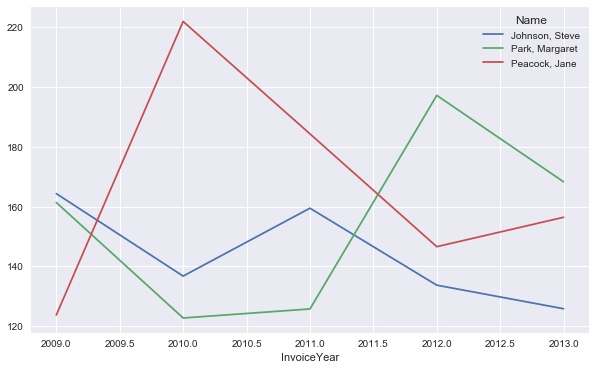

In [226]:
sales_plot = sales_pivot['Total'].transpose().plot()

In [227]:
import os
import tempfile
temp_file = os.path.join(tempfile.gettempdir(), "chart.png")
fig = sales_plot.get_figure()
fig.savefig(temp_file)

In [228]:
sales_report.add_picture(temp_file, 
                         width=docx.shared.Inches(6))

In [229]:
sales_report.save("./data/07-report.docx")